# CAPSTONE 2 - DATAFLIX



In [1]:
import pandas as pd
import ast
import json
import re
from datetime import datetime

# =========================================================
# Step 1: Utility Functions
# =========================================================

def parse_json_column(col_value):
    """
    Safely parse a JSON-like string into a Python object (list/dict).
    Handles edge cases: empty strings, NaN, single quotes, etc.
    """
    if pd.isna(col_value) or not isinstance(col_value, str) or not col_value.strip():
        return []
    try:
        return ast.literal_eval(col_value)
    except:
        try:
            return json.loads(col_value.replace("'", '"'))
        except:
            return []

def extract_field(json_list, field_name):
    """
    Extract specific field values from a list of dictionaries.
    """
    if not isinstance(json_list, list):
        return ''
    return ', '.join([d.get(field_name, '') for d in json_list])

def extract_directors(crew_list):
    """
    Extract all directors' names from the crew list.
    """
    if not isinstance(crew_list, list):
        return ''
    return ', '.join([member.get('name', '') for member in crew_list if member.get('job') == 'Director'])

def standardize_date(date_str):
    """
    Convert dates like '2/20/15' to 'YYYY-MM-DD'. Adjust years > 2017 by subtracting 100.
    """
    if pd.isna(date_str) or not isinstance(date_str, str) or not date_str.strip():
        return None
    try:
        dt = datetime.strptime(date_str, '%m/%d/%y')
        year = dt.year
        if year > 2017:  # Fix incorrect future years
            year -= 100
        return dt.replace(year=year).strftime('%Y-%m-%d')
    except ValueError:
        return None

def fix_text_encoding(val):
    """
    Fix known text encoding issues and clean strings.
    """
    if isinstance(val, str):
        val = val.replace("√©", "é")  # Example: Fix specific encoding issues
        val = re.sub(r'[\\"]', '', val)  # Remove backslashes and quotes
        return val.strip()
    return val

# =========================================================
# Step 2: Load Data
# =========================================================

df = pd.read_csv('data/tmdb-box-office-prediction/train.csv')

# =========================================================
# Step 3: Parse and Clean Data
# =========================================================

# Parse JSON-like columns
json_cols = [
    'genres', 'Keywords', 'cast', 'crew',
    'production_companies', 'production_countries',
    'spoken_languages', 'belongs_to_collection'
]
for col in json_cols:
    df[col] = df[col].apply(parse_json_column)

# Extract useful fields
df['genres_extracted'] = df['genres'].apply(lambda x: extract_field(x, 'name'))
df['keywords_extracted'] = df['Keywords'].apply(lambda x: extract_field(x, 'name'))
df['top_cast'] = df['cast'].apply(lambda x: ', '.join(d.get('name', '') for d in x[:3]))  # Top 3 cast
df['directors'] = df['crew'].apply(extract_directors)
df['production_companies_extracted'] = df['production_companies'].apply(lambda x: extract_field(x, 'name'))
df['production_countries_extracted'] = df['production_countries'].apply(lambda x: extract_field(x, 'name'))
df['spoken_languages_extracted'] = df['spoken_languages'].apply(lambda x: extract_field(x, 'name'))
df['collection_name'] = df['belongs_to_collection'].apply(
    lambda x: x[0]['name'] if isinstance(x, list) and x and 'name' in x[0] else ''
)

# Standardize release_date and adjust years
df['release_date'] = df['release_date'].apply(standardize_date)

# Fix text encoding issues
text_cols_to_fix = [
    'overview', 'top_cast', 'directors', 'genres_extracted',
    'keywords_extracted', 'collection_name', 'title'
]
for col in text_cols_to_fix:
    df[col] = df[col].apply(fix_text_encoding)

# Replace underscores in keywords with spaces
df['keywords_extracted'] = df['keywords_extracted'].str.replace('_', ' ')

# Fill missing text fields with blank
df[text_cols_to_fix] = df[text_cols_to_fix].fillna('')

# =========================================================
# Step 4: Handle Missing Values and Drop Irrelevant Columns
# =========================================================

# Fill missing numeric fields
if 'runtime' in df.columns:
    df['runtime'].fillna(df['runtime'].median(), inplace=True)

# Replace zeros in budget/revenue with NaN and impute
for col in ['budget', 'revenue']:
    df[col].replace(0, pd.NA, inplace=True)
    df[col].fillna(df[col].median(), inplace=True)

# Drop irrelevant columns
cols_to_drop = [
    'genres', 'Keywords', 'cast', 'crew', 'production_companies',
    'production_countries', 'spoken_languages', 'belongs_to_collection',
    'poster_path', 'homepage'
]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# =========================================================
# Step 5: Save the Cleaned Data
# =========================================================

df.to_csv('data/cleaned_movies.csv', index=False)
print("Cleaned data has been saved to 'cleaned_movies.csv'.")


/tmp/ipykernel_28284/2555393748.py:121: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['runtime'].fillna(df['runtime'].median(), inplace=True)
/tmp/ipykernel_28284/2555393748.py:125: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpl

Cleaned data has been saved to 'cleaned_movies.csv'.



--- DATA SHAPE ---
Rows: 3000, Columns: 21

--- MISSING VALUES ---
id                                  0
budget                              0
imdb_id                             0
original_language                   0
original_title                      0
overview                            0
popularity                          0
release_date                        0
runtime                             0
status                              0
tagline                           597
title                               0
revenue                             0
genres_extracted                    0
keywords_extracted                  0
top_cast                            0
directors                           0
production_companies_extracted      0
production_countries_extracted      0
spoken_languages_extracted          0
collection_name                     0
dtype: int64

--- DESCRIPTIVE STATISTICS (NUMERIC) ---
                id        budget   popularity      runtime       revenue
count 

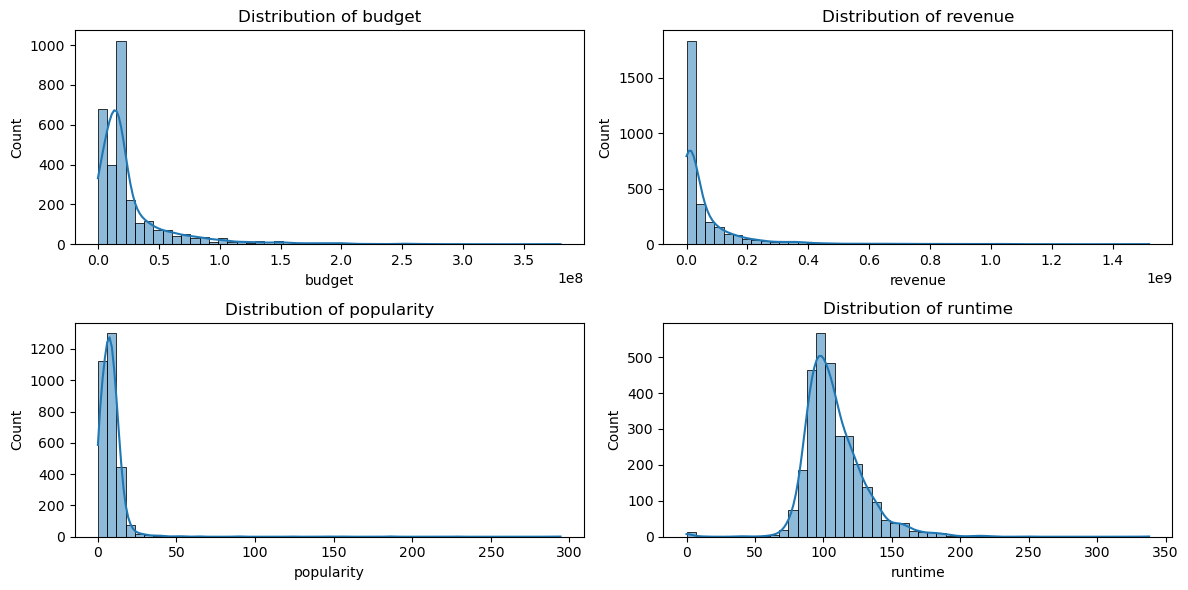

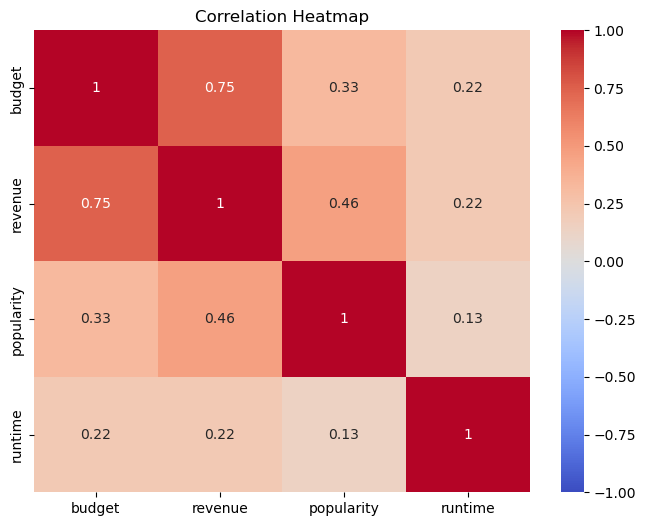


--- TOP 5 MOVIES BY REVENUE ---
                               title     revenue       budget  popularity
1126                    The Avengers  1519557910  220000000.0   89.887648
1761                       Furious 7  1506249360  190000000.0   27.275687
2770         Avengers: Age of Ultron  1405403694  280000000.0   37.379420
684             Beauty and the Beast  1262886337  160000000.0  287.253654
2322  Transformers: Dark of the Moon  1123746996  195000000.0    4.503505

--- BOTTOM 5 MOVIES BY REVENUE ---
                        title  revenue      budget  popularity
347   The Wind in the Willows        1        12.0    1.410322
1754             Mute Witness        1         2.0    2.466066
1874                  Missing        1  16000000.0    0.229233
1917          The Merry Widow        1       592.0    0.286719
695                 Tere Naam        2         1.0    1.280455

--- TOP 5 MOVIES BY BUDGET ---
                                            title       budget     revenue
21

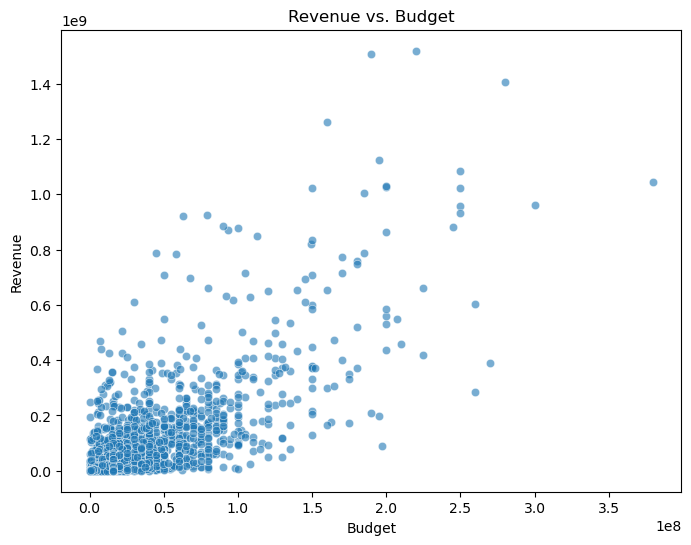

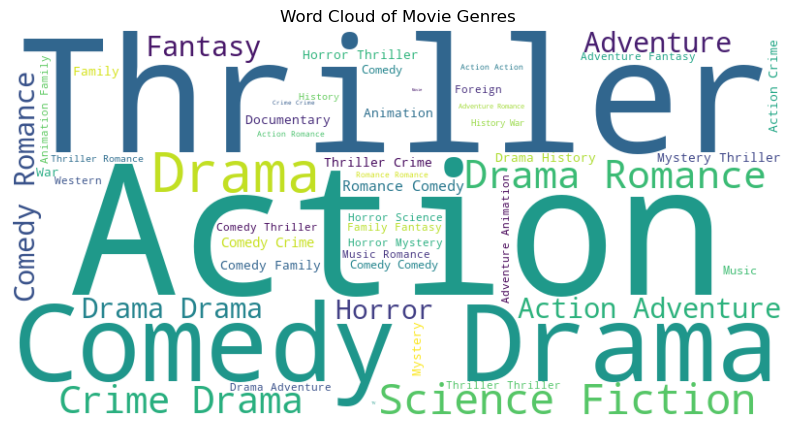


--- TOP 10 MOST COMMON KEYWORDS ---
[('woman director', 175), ('independent film', 155), ('duringcreditsstinger', 134), ('murder', 123), ('based on novel', 111), ('violence', 87), ('sport', 82), ('biography', 77), ('aftercreditsstinger', 75), ('dystopia', 73)]


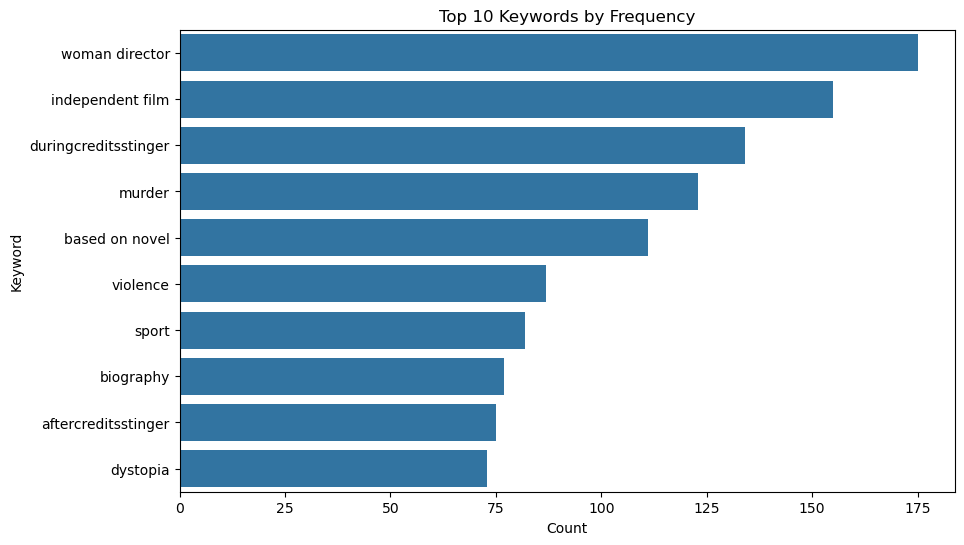

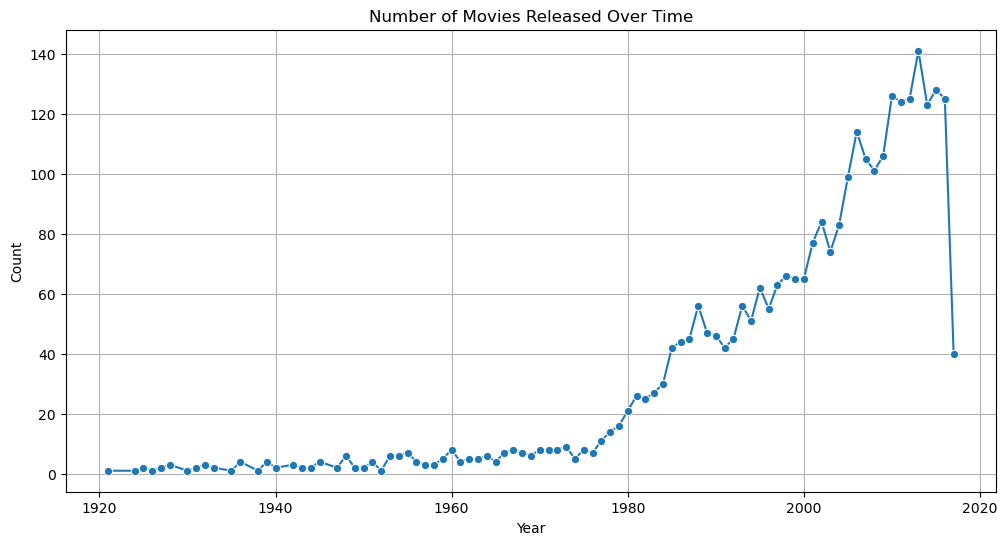


--- TOP 10 DIRECTORS BY AVERAGE REVENUE ---
directors
Joss Whedon                             1.462481e+09
Andrew Stanton, Angus MacLane           1.028571e+09
Byron Howard, Rich Moore, Jared Bush    1.023784e+09
David Yates                             9.339592e+08
James Gunn                              8.183724e+08
Roger Allers, Rob Minkoff               7.882418e+08
Tim Miller                              7.831130e+08
Robert Stromberg                        7.585398e+08
Alfonso Cuar√≥n                         7.163927e+08
Anthony Russo, Joe Russo                7.147666e+08
Name: revenue, dtype: float64


/tmp/ipykernel_28284/4136919393.py:143: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_directors.values, y=top_directors.index, palette="viridis")


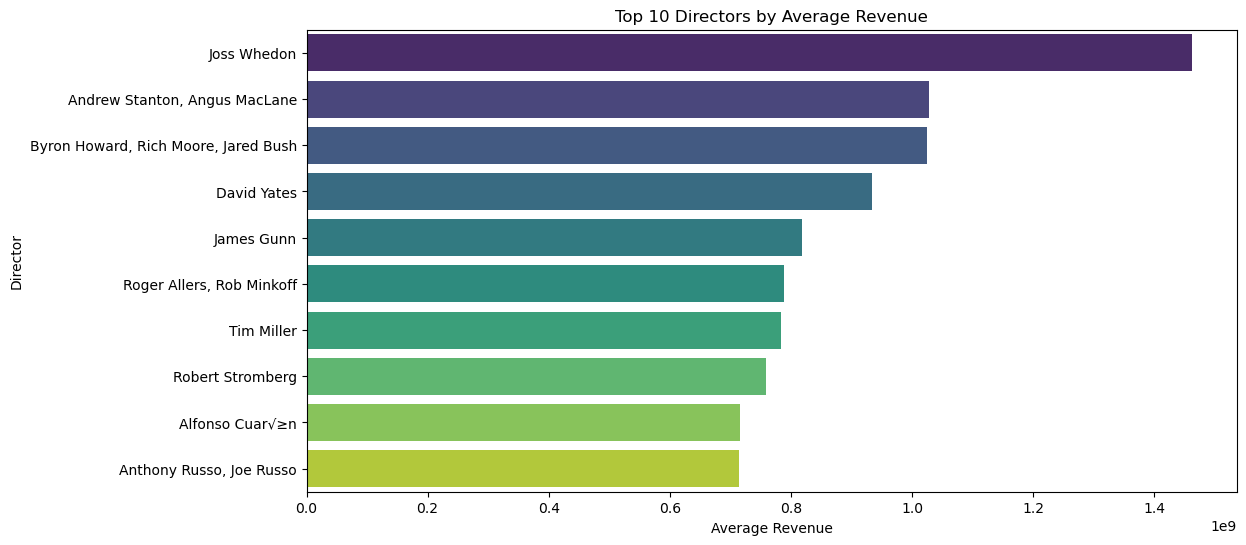

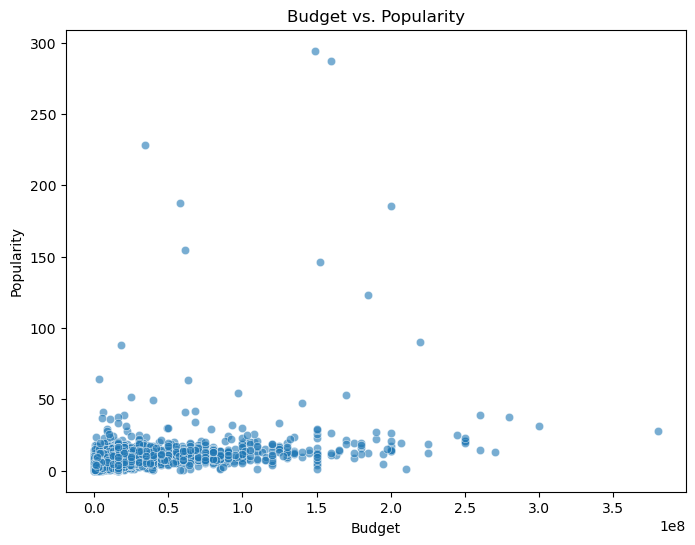

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =========================================================
# Step 1: Basic Data Overview
# =========================================================

print("\n--- DATA SHAPE ---")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

print("\n--- MISSING VALUES ---")
print(df.isnull().sum())

print("\n--- DESCRIPTIVE STATISTICS (NUMERIC) ---")
print(df.describe())

# =========================================================
# Step 2: Numeric Feature Distributions
# =========================================================

# Features to visualize
numeric_features = ['budget', 'revenue', 'popularity', 'runtime']

# Plot histograms for numeric features
plt.figure(figsize=(12, 6))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[feature], bins=50, kde=True)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

# =========================================================
# Step 3: Correlation Heatmap
# =========================================================

# Correlation between numeric features
correlation_matrix = df[numeric_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# =========================================================
# Step 4: Revenue Analysis
# =========================================================

# Top 5 movies by revenue
print("\n--- TOP 5 MOVIES BY REVENUE ---")
print(df.nlargest(5, 'revenue')[['title', 'revenue', 'budget', 'popularity']])

# Bottom 5 movies by revenue
print("\n--- BOTTOM 5 MOVIES BY REVENUE ---")
print(df.nsmallest(5, 'revenue')[['title', 'revenue', 'budget', 'popularity']])


# Top 5 highest budgets
print("\n--- TOP 5 MOVIES BY BUDGET ---")
print(df.nlargest(5, 'budget')[['title', 'budget', 'revenue']])

# Top 5 highest popularities
print("\n--- TOP 5 MOVIES BY POPULARITY ---")
print(df.nlargest(5, 'popularity')[['title', 'popularity', 'revenue']])

# Scatter plot: Revenue vs. Budget
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='budget', y='revenue', alpha=0.6)
plt.title("Revenue vs. Budget")
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.show()

# =========================================================
# Step 5: Genre and Keywords Analysis
# =========================================================

# Word cloud for genres
from wordcloud import WordCloud

genre_text = ' '.join(df['genres_extracted'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(genre_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Movie Genres")
plt.show()

# Most common keywords
from collections import Counter

# Join the keywords, split by comma, and filter out any empty strings
all_keywords = [kw.strip() for kw in ','.join(df['keywords_extracted'].dropna()).split(',') if kw.strip() != '']

keywords_counter = Counter(all_keywords)
most_common_keywords = keywords_counter.most_common(10)

print("\n--- TOP 10 MOST COMMON KEYWORDS ---")
print(most_common_keywords)

# Bar plot for most common keywords
keywords, counts = zip(*most_common_keywords)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(counts), y=list(keywords), orient='h')
plt.title("Top 10 Keywords by Frequency")
plt.xlabel("Count")
plt.ylabel("Keyword")
plt.show()

# =========================================================
# Step 6: Release Date Analysis
# =========================================================

# Ensure release_date is datetime
if 'release_date' in df.columns:
    df['release_year'] = pd.to_datetime(df['release_date']).dt.year

# Movie count by release year
yearly_counts = df['release_year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=yearly_counts.index, y=yearly_counts.values, marker='o')
plt.title("Number of Movies Released Over Time")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid()
plt.show()

# =========================================================
# Step 7: Revenue by Top Directors
# =========================================================

# Group by directors and calculate average revenue
top_directors = df.groupby('directors')['revenue'].mean().sort_values(ascending=False).head(10)

print("\n--- TOP 10 DIRECTORS BY AVERAGE REVENUE ---")
print(top_directors)

# Bar plot: Top 10 directors by average revenue
plt.figure(figsize=(12, 6))
sns.barplot(x=top_directors.values, y=top_directors.index, palette="viridis")
plt.title("Top 10 Directors by Average Revenue")
plt.xlabel("Average Revenue")
plt.ylabel("Director")
plt.show()

# =========================================================
# Step 8: Budget vs. Popularity Interaction
# =========================================================

# Scatter plot: Budget vs. Popularity
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='budget', y='popularity', alpha=0.6)
plt.title("Budget vs. Popularity")
plt.xlabel("Budget")
plt.ylabel("Popularity")
plt.show()

